In [1]:
import os
import sys
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
import importlib
import numpy as np
import matplotlib as mpl
import colossus.halo.mass_adv as massdefs
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.ticker as tik
from Functions import Functions as F
from Scripts.Plots import SDSS_Plots
Add_SDSS = SDSS_Plots.SDSS_Plots(11.5,15,0.1) #pass this halomass:min, max, and binwidth for amting the SDSS plots
from colossus.cosmology import cosmology
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()
HMF_fun = F.Make_HMF_Interp() #N Mpc^-3 h^3 dex^-1, Args are (Mass, Redshift)
h = Cosmo.h
h_3 = h*h*h

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/data/pg1g15/STEEL/Notebooks/Plots/../../Scripts/Plots/SDSS_Plots.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

FRACKSKY= 0.1404020420493216


In [ ]:
importlib.reload(F)

In [ ]:
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size']=15
plt.rcParams['lines.linewidth']=2

In [2]:
#Abundance Matching Parameters
Override =\
{\
'M10':12.0,\
'SHMnorm10':0.032,\
'beta10':1.5,\
'gamma10':0.56,\
'M11':0.6,\
'SHMnorm11':-0.014,\
'beta11':-0.7,\
'gamma11':0.08\
}

AbnMtch =\
{\
'Behroozi13': False,\
'Behroozi18': False,\
'B18c':False,\
'B18t':False,\
'G18':False,\
'G18_notSE':False,\
'G19_SE':False,\
'G19_cMod':False,\
'Lorenzo18':False,\
'Moster': False,\
'Moster10': False,\
'Illustris':False,\
'z_Evo':True,\
'Scatter': 0.15,\
'Override_0': False,\
'Override_z': False,\
'Override': Override,\
'PFT': False,\
'M_PFT1': False,\
'M_PFT2': False,\
'M_PFT3': False,\
'N_PFT1': False,\
'N_PFT2': False,\
'N_PFT3': False,\
'b_PFT1': False,\
'b_PFT2': False,\
'b_PFT3': False,\
'g_PFT1': False,\
'g_PFT2': False,\
'g_PFT3': False\
}

Paramaters = \
{\
'AbnMtch' : AbnMtch,\
'AltDynamicalTime': 1,\
'NormRnd': 0.5,\
'SFR_Model': 'CE'\
}

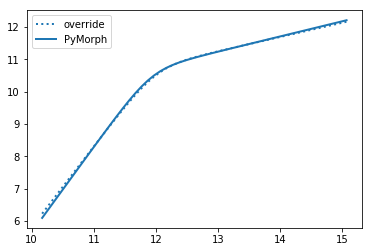

[ 9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3
 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7
 11.8 11.9 12.  12.1 12.2 12.3 12.4]
[ 9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7  9.8  9.9 10.  10.1 10.2 10.3
 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1 11.2 11.3 11.4 11.5 11.6 11.7
 11.8 11.9 12.  12.1 12.2 12.3 12.4]


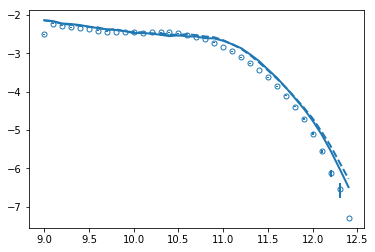

In [3]:

AbnMtch['Override_z'] = True
plt.plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), ":C0", label = "override")

AbnMtch['Override_z'] = False

AbnMtch['G19_SE'] = True
plt.plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "PyMorph")
AbnMtch['G19_SE'] = False
plt.legend()
plt.show()


SMR_L = 9
SMR_U = 12.5
SMR_BW = 0.1
SMF_Bins, Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e =  Add_SDSS.SMF_Data(SMF_Bins = np.arange(SMR_L, SMR_U , SMR_BW))
#axarr[1].errorbar(np.divide(SMF_Bins[1:]+SMF_Bins[:-1], 2), Y_cen, yerr=Y_cen_e, fmt = "o", label = "SDSS_PyMorph", mfc = "None")
plt.errorbar(np.arange(SMR_L, SMR_U , SMR_BW), Y_cen, yerr=Y_cen_e, fmt = "oC0", label = "SDSS_PyMorph", mfc = "None")


SM_bin = 0.1
Redshift = 0.1
Halo_bin = 0.1
Halo_MR = np.arange(10, 16, Halo_bin)
AbnMtch['Override_z'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 2500)[1]
plt.plot(np.arange(SMR_L, SMR_U , SMR_BW), SMF, "-C0")
AbnMtch['Override_z'] = False

AbnMtch['G19_SE'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 2500)[1]
plt.plot(np.arange(SMR_L, SMR_U , SMR_BW), SMF, "--C0")
AbnMtch['G19_SE'] = False

print(np.arange(SMR_L, SMR_U , SMR_BW))
print(SMF_Bins)

plt.show()

Plot For abundance matching

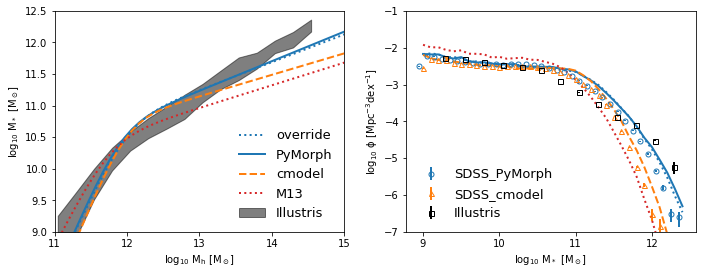

In [4]:
def Shank17AM(HM, ScatterOn = False):
    Mstar0 = 10.68
    Mhalo0 = 11.8
    alpha = 2.13
    beta = 1.68
    
    Part1 = np.power(10, alpha*(HM-Mhalo0))
    Part2 = np.power(1+np.power(10,beta*(HM-Mhalo0)), -1)
    if ScatterOn:
        Scatter = np.random.normal(scale = 0.15, size = np.shape(HM))
        return Mstar0 + np.log10(Part1*Part2) + Scatter
    else:
        return Mstar0 + np.log10(Part1*Part2)
def DM_to_SM_for_S17(SMF_X, HMF, Halo_MR, HMF_Bin, SMF_Bin, Paramaters, Redshift = 0, N = 5000):
    """
    Input
    SMF_X: Stellar Mass Function Mass Range log10[$M_\odot$]
    HMF: Halo Mass Function Weights log10[ $\Phi$ Mpc^{-3} h^3]
    Halo_MR: Halo Mass Function Mass Range log10[$M_\odot$ h^{-1}]
    HMF_Bin: Binwidth of Halo_MR
    SMF_Bin: Binwidth of SMF_X
    N: number of times to use
    """

    DM_In = np.repeat(Halo_MR - np.log10(h), N) #log Mh [Msun]
    Wt = np.repeat(np.divide(np.power(10, HMF + 3*np.log10(h))*HMF_Bin, N), N) #Phi/N [Mpc^-3]
    
    SM = Shank17AM(DM_In, ScatterOn = True) #log M* [Msun]
    
    #SM = np.log10(HM_SM.mean_stellar_mass(prim_haloprop = 10**(DM_In + np.log10(0.704)) )) - np.log10(0.704) + np.random.normal(scale = 0.1, size = np.shape(DM_In))
    
    SMF_Y, Bin_Edge = np.histogram(SM, bins = np.append(SMF_X, SMF_X[-1]+SMF_Bin), weights = Wt) #Phi [Mpc^-3], M* [Msun]
    
    return SMF_X, np.log10(np.divide(SMF_Y, SMF_Bin)) #M* [Msun], Phi [Mpc^-3]

X = np.arange(10, 15, 0.1) #M h-1 #virial
f, axarr = plt.subplots(1, 2, figsize=(10,4))

SMR_L = 9
SMR_U = 12.5
SMR_BW = 0.1
SMF_Bins, Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e =  Add_SDSS.SMF_Data(SMF_Bins = np.append(np.arange(SMR_L, SMR_U , SMR_BW), np.max(np.arange(SMR_L, SMR_U , SMR_BW)) + SMR_BW) -(SMR_BW/2) )
#axarr[1].errorbar(np.divide(SMF_Bins[1:]+SMF_Bins[:-1], 2), Y_cen, yerr=Y_cen_e, fmt = "o", label = "SDSS_PyMorph", mfc = "None")
axarr[1].errorbar(SMF_Bins, Y_cen, yerr=Y_cen_e, fmt = "o", label = "SDSS_PyMorph", mfc = "None")
#axarr[1].errorbar(SMF_Bins[:-1], Y_t, yerr=Y_t_e, label = "t_SE")

SMF_Bins, Y_t, Y_t_e, Y_sat, Y_sat_e, Y_cen, Y_cen_e =  Add_SDSS.SMF_Data(OverridePhoto = "MsMendCmodel")
axarr[1].errorbar(SMF_Bins, Y_cen, yerr=Y_cen_e, fmt = "^", label = "SDSS_cmodel", mfc = "None")
#axarr[1].errorbar(SMF_Bins[:-1], Y_t, yerr=Y_t_e, label = "t_cMod")

#axarr[0].plot(X- np.log10(h), Shank17AM(np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, X), z=0.1, mdef_in='vir', mdef_out='200c')[0]) - np.log10(h)), "vC8",label = "S17", mfc = 'none')


AbnMtch['Override_z'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), ":C0", label = "override")
"""
Override['beta10'] += 0.854
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "G19")
Override['beta10'] -= 0.854
Override['beta10'] -= 0.73
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "G19")
Override['beta10'] += 0.73
"""
AbnMtch['Override_z'] = False

AbnMtch['G19_SE'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "PyMorph")
AbnMtch['G19_SE'] = False


AbnMtch['G19_cMod'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "--C1", label = "cmodel")
AbnMtch['G19_cMod'] = False
"""
AbnMtch['Behroozi18'] = True
AbnMtch['B18c'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass_Alt(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-.C2",label = "B18")
AbnMtch['B18c'] = False
AbnMtch['Behroozi18'] = False
"""
AbnMtch['Moster'] = True
axarr[0].plot(X- np.log10(h), F.DarkMatterToStellarMass(np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, X), z=0.1, mdef_in='vir', mdef_out='200c')[0]) - np.log10(h), 0.1, Paramaters, ScatterOn = False), ":C3" ,label = "M13")
AbnMtch['Moster'] = False



#F.DM_to_SM(SMF_X, HMF, Halo_MR, HMF_Bin, SMF_Bin, Paramaters, Redshift = 0, N = 5000, UseAlt = False)
Redshift = 0.1
SM_bin = SMF_Bins[1] - SMF_Bins[0]
Halo_bin = 0.1
Halo_MR = np.arange(10, 16, Halo_bin)
Halo_MR_m200 = np.log10(massdefs.changeMassDefinitionCModel(M=np.power(10, Halo_MR), z=0.1, mdef_in='vir', mdef_out='200c')[0])

AbnMtch['Override_z'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, ":C0")
"""
Override['beta10'] += 0.854
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "-C0")
Override['beta10'] -= 0.854
Override['beta10'] -= 0.73
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "-C0")
Override['beta10'] += 0.73
"""
AbnMtch['Override_z'] = False



AbnMtch['G19_SE'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "-C0")
AbnMtch['G19_SE'] = False
AbnMtch['G19_cMod'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "--C1")
AbnMtch['G19_cMod'] = False
"""
AbnMtch['Behroozi18'] = True
AbnMtch['B18c'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR_m200, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000, UseAlt = True)[1]
plt.plot(SMF_Bins, SMF, "-.C2")
AbnMtch['B18c'] = False
AbnMtch['Behroozi18'] = False
"""
AbnMtch['Moster'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR_m200, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, ":C3")
AbnMtch['Moster'] = False


SMHM_ill = np.load(AbsPath+'/Data/Observational/Illustris/SMHM_fillbtwn_99.npy')
axarr[0].fill_between(SMHM_ill[0], SMHM_ill[1], SMHM_ill[2], color = 'k', alpha = 0.5, label = 'Illustris')
SMF_ill = np.load(AbsPath+'/Data/Observational/Illustris/SMF_errbar_99.npy')
axarr[1].errorbar(SMF_ill[0], SMF_ill[1], yerr = [SMF_ill[2], SMF_ill[3]], color = 'k',  fmt = "s", label = 'Illustris', mfc = None, fillstyle = "none")

mpl.rcParams.update({'font.size': 13})
axarr[0].legend(loc = 4, frameon = False)
#axarr[1].legend(handles=lines_plotted, loc = 3, frameon = False)
axarr[1].legend(frameon = False)




axarr[0].set_ylim(9, 12.5)
axarr[0].set_xlim(11, 15)
axarr[1].set_ylim(-7, -1)
axarr[0].set_xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
axarr[0].set_ylabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
axarr[1].set_xlabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
axarr[1].set_ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
                                                                            
plt.tight_layout()

plt.savefig(AbsPath+"/Figures/Paper2/AbundaceMtch_lowz.png")
plt.savefig(AbsPath+"/Figures/Paper2/AbundaceMtch_lowz.pdf")

plt.show()

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


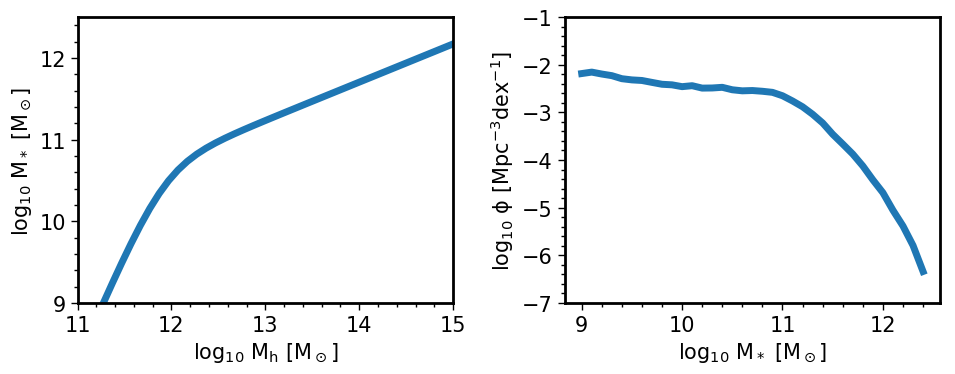

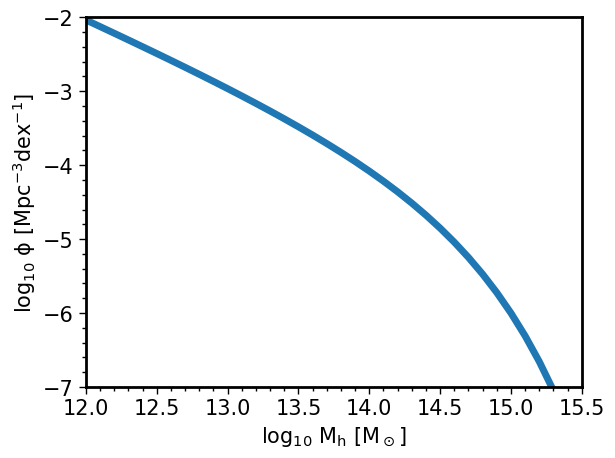

In [5]:
#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20
plt.rcParams['font.size']=15
plt.rcParams['lines.linewidth']=5

X = np.arange(10, 15, 0.1) #M h-1 #virial
f, axarr = plt.subplots(1, 2, figsize=(10,4))

AbnMtch['G19_SE'] = True
axarr[0].plot(np.arange(10, 15, 0.1)- np.log10(h), F.DarkMatterToStellarMass(np.arange(10, 15, 0.1) - np.log10(h), 0.1, Paramaters, ScatterOn = False), "-C0", label = "G19")
AbnMtch['G19_SE'] = False
AbnMtch['G19_SE'] = True
SMF = F.DM_to_SM(SMF_Bins, np.log10(HMF_fun(Halo_MR, Redshift)), Halo_MR, Halo_bin, SM_bin, Paramaters, Redshift = Redshift, N = 1000)[1]
plt.plot(SMF_Bins, SMF, "-C0")
AbnMtch['G19_SE'] = False

axarr[0].set_ylim(9, 12.5)
axarr[0].set_xlim(11, 15)
axarr[1].set_ylim(-7, -1)
axarr[0].set_xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
axarr[0].set_ylabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
axarr[1].set_xlabel("$\mathrm{log_{10}}$ $\mathrm{M_*}$ $\mathrm{[M_\odot]}$")
axarr[1].set_ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
plt.tight_layout()
plt.show()


plt.plot(Halo_MR,np.log10(HMF_fun(Halo_MR, Redshift)))
plt.xlabel("$\mathrm{log_{10}}$ $\mathrm{M_h}$ $\mathrm{[M_\odot]}$")
plt.ylabel("$\mathrm{log_{10}}$ $\mathrm{\phi}$ $\mathrm{[Mpc^{-3}dex^{-1}]}$")
plt.xlim(12, 15.5)
plt.ylim(-7, -2)
plt.show()


In [ ]:
plt.rcParams.keys()